# Yelp@Me
### Mimi Doan, Stephanie McAleer, Jeremy Muhia

Our data product allows users to input an address and find the top six restaurants from the user submitted data. Through research, we were able to discover that the way that Yelp returns its list of restaurant is very black boxed--existence of reviews, reviews by 'elite' Yelp members, check-ins via smartphone, etc. There’s no way for users to understand how businesses are served to them by Yelp, and we wanted to give users the option of utilizing a more transparent search mechanism while still leveraging Yelp’s business authentication feature.

Our home page at [pwnrs.herokuapp.com/yelp](pwnrs.herokuapp.com/yelp) renders the form for users to search based on their desired location. Upon clicking the 'Find a Restaurant' button, a new page is rendered in which our top 6 restuarants are displayed in a grid with the accompanying image url that we parsed from the API. 

Below the restaurant grid, we graph the distribution of the ratings of restaurants at that specific location as well as the search frequency trend for that location.

In [1]:
# imports for our Flask Application
from flask import Flask
from flask import render_template
from flask_sqlalchemy import SQLAlchemy
from datetime import datetime as dt
from flask import request
from flask import redirect

# matplotlib.use('Agg')
%matplotlib inline
import matplotlib

import os
import scrapy
import api_helper
import urllib.parse as urlparse
import psycopg2

import sys                             # system module
import pandas as pd                    # data package
import matplotlib.pyplot as plt, mpld3        # graphics module
import numpy as np                     # foundation for Pandas


app = Flask(
    __name__,
    template_folder="templates",
    static_folder="static"
)


# config for DB schematics
app.config['SQLALCHEMY_DATABASE_URI'] = os.environ['DATABASE_URL']
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
db = SQLAlchemy(app)


# Locaiton data model
class Location(db.Model):
    """docstring for Location."""
    id = db.Column(db.Integer, primary_key=True)
    location = db.Column(db.Text, nullable=False)
    created_at = db.Column(db.DateTime, nullable=False, default=dt.utcnow())

    def __init__(self, location):
        self.location = location

    def __repr__(self):
        return '<Location %s>' % self.location

    def __str__(self):
        return '%s' % self.location


def construct_address(*args):
    return ' '.join(args).strip()


def get_n_businesses(n, businesses):
    best = get_normal_scores(n, businesses)
    top_n = []
    for business in businesses:
        if business['name'] in best.index:
            one_business = {}
            for key in business.keys():
                if key in ['name', 'url', 'image_url', 'rating', 'price']:
                    one_business[key] = business[key]
            top_n.append(one_business)
    return top_n


def get_all_ratings(businesses):
    return [business.get('rating') for business in businesses if business.get('rating') != None]


def get_normal_scores(n, businesses):
    raw_data = {}
    for business in businesses:
        columns = [business.get('price'), business.get('rating'), business.get('review_count')]
        if None not in columns:
            columns[0] = len(columns[0])
            raw_data[business.get('name')] = columns
    df = pd.DataFrame.from_dict(raw_data, orient='index')
    normal = (df - df.min()) / (df.max() - df.min())
    normal['score'] = normal[0] + normal[1] + normal[2]
    top_places = normal.nlargest(n, 'score')
    return top_places


# helper func for adding location to DB
def add_location_to_db(address):
    location = Location(address)
    db.session.add(location)
    db.session.commit()


# get the locations with the most searches
def get_frequent_locations(num_locations):
    locations = db.session.query(Location.location, db.func.count(Location.location).label('Searches'))\
        .group_by(Location.location)\
        .order_by(db.desc('Searches'))\
        .limit(num_locations)\
        .all()
    return locations


def get_location_trend(location):
    location_trends = db.session.query(db.func.DATE(Location.created_at).label('Date'), db.func.count(db.func.DATE(Location.created_at)).label('Searches'))\
        .filter(Location.location == location)\
        .group_by(db.func.DATE(Location.created_at))\
        .all()
    return location_trends


def get_search_trend_vis(location):
    location_trends = get_location_trend(location)
    before_df = {}
    for data in location_trends:
        before_df[data[0]] = data[1]
    df = pd.DataFrame.from_dict(before_df, orient='index')
    df = df.reset_index()
    return df


### Data model

The most important part of this model allows us to include a timeseries analysis each time a location is searched. Specifically, the `created_at` column is what makes this possible. We can make an aggregate query on this column after grouping by a location. With this data, we can show search trends for a specific location as well as all locations to make a trending list. It's also important to note that we do this using SQLAlchemy, which has a python API for interracting with Postgres.

In [2]:
# config for DB schematics
app.config['SQLALCHEMY_DATABASE_URI'] = os.environ['DATABASE_URL']
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
db = SQLAlchemy(app)


# Locaiton data model
class Location(db.Model):
    """docstring for Location."""
    id = db.Column(db.Integer, primary_key=True)
    location = db.Column(db.Text, nullable=False)
    created_at = db.Column(db.DateTime, nullable=False, default=dt.utcnow())

    def __init__(self, location):
        self.location = location

    def __repr__(self):
        return '<Location %s>' % self.location

    def __str__(self):
        return '%s' % self.location


### Getting and analyzing restaurants from Yelp

We begin our analysis by making an API call to fetch 50 restaurants from Yelp. Given performance limitations when thinking about request/response latency on a single deployment node, in addition to Yelp's somewhat arbitrary selection of restaurants to return from their API, we choose to limit the result set to 50. Error checking and overall quality is improved by protecting against invalid user input.

In [3]:
import os
import requests

base_yelp_url = 'https://api.yelp.com/v3/businesses/search'
headers = {'Authorization': 'Bearer ' + os.environ['YELP_API_KEY']}
params = {'term': 'food', 'limit': 50}

def get_food_at_location(location):
    if invalid(location):
        return None
    params['location'] = location
    resp = requests.get(base_yelp_url, params=params, headers=headers)
    return resp

def invalid(value):
    return value == None or value == '' or type(value) != str


In [4]:
request = get_food_at_location('New York, NY')
response = request.json()['businesses']
print('We get back', len(response), 'restaurants from Yelp.')

We get back 50 restaurants from Yelp.


Now that we've searched for restaurants in `New York, NY`, the first step is to construct a visualization of how this location is trending in search popularity. This includes querying our database for this location and calculating how many times this location has been searched on our platform grouped by date. The results of this query, are seen in the `DataFrame` below.

In [5]:
df_1 = get_search_trend_vis('New York, NY')
df_1

,index,0
0,2017-12-13,31
1,2017-12-09,2
2,2017-12-14,1
3,2017-12-08,2


The corresponding visualization is below.

Text(0.5,0,'Date')

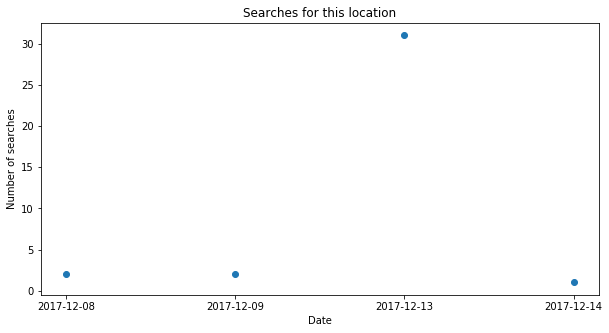

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    df_1['index'].map(lambda x: x.strftime('%Y-%m-%d')).tolist(),
    df_1[0].tolist(),
    linestyle='None',
    marker='o'
)
ax.set_title('Searches for this location')
ax.set_ylabel('Number of searches')
ax.set_xlabel('Date')

We also visualize the the distribution of how restaurants are rated at this location. We expect to see that most restaurant ratings will cluster in the 4 star region. This reasoning is driven by the assumption that Yelp critics often give polarized ratings (1 star or 4 to 5 stars). However, lower ratings are unlikely to occur unless in extreme instances of dissatisfaction.

Text(0.5,0,'Rating')

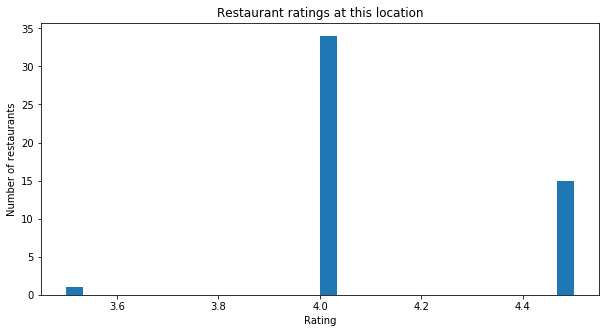

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(
    x=get_all_ratings(response),
    bins=30,
    histtype='stepfilled'
)
ax.set_title('Restaurant ratings at this location')
ax.set_ylabel('Number of restaurants')
ax.set_xlabel('Rating')

Finally, when we get data for all restaurants at a location, we run an analysis of these restaurants in order to choose the best suggestions. The analysis is based on three fields: `price`, `rating`, and `review_count`. These fields are chosen in order to identify the best, cheapest restaurants. Also, the importance of each field is considered equally. We make this choice because we assume that users of our data product want a balanced review. We normalize this data so that a restaurant with an oddly extreme value for any one of the three fields is easily comparable to restaurants with values closer to the mean.

In [8]:
def get_normal_scores(n, businesses):
    raw_data = {}
    for business in businesses:
        columns = [business.get('price'), business.get('rating'), business.get('review_count')]
        if None not in columns:
            columns[0] = len(columns[0])
            raw_data[business.get('name')] = columns
    df = pd.DataFrame.from_dict(raw_data, orient='index')
    normal = (df - df.min()) / (df.max() - df.min())
    normal['score'] = normal[0] + normal[1] + normal[2]
    top_places = normal.nlargest(n, 'score')
    return top_places

get_normal_scores(50, response)

,0,1,2,score
Ippudo East Village,1.0,0.5,1.000000,2.500000
Amélie,1.0,1.0,0.201575,2.201575
The Boil,1.0,1.0,0.166852,2.166852
Juliana's Pizza,1.0,1.0,0.161637,2.161637
Luke's Lobster FiDi,1.0,1.0,0.093521,2.093521
Thursday Kitchen,1.0,1.0,0.072887,2.072887
Flip Sigi,1.0,1.0,0.046150,2.046150
Joe's Shanghai,1.0,0.5,0.520080,2.020080
Ramen Shack,1.0,1.0,0.005436,2.005436
Eataly,1.0,0.5,0.504216,2.004216


The `DataFrame` above shows how all the restaurants returned by the Yelp API are ranked.